In [1]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set up auto load
%load_ext autoreload
%autoreload 2

In [21]:
from load_data import *

plt.rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


In [22]:
train_ticker_strings = []
for filename in os.listdir('price'):
  if filename != 'MSFT.csv':
    train_ticker_strings.append(filename[:-4])
print(train_ticker_strings)
#train_ticker_strings = ["AAPL", "ABB", "ABBV", "AEP", "AGFS", "AMGN", "AMZN", "BA", "BABA", "BAC", "BBL", "BCH", "BHP", "BP", "BRK-A", "BSAC", "BUD", "C", "CAT", "CELG", "CHL", "CHTR", "CMCSA", "CODI", "CSCO", "CVX", "D", "FB", "PEP", "ORCL", "UPS", "GOOG", "KO", "JPM", "PCG", ]
look_back = 30
train_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings, look_back=look_back)
print("train data size (in batches):", len(train_data_loader))

['MMM', 'CVX', 'HRG', 'MRK', 'PICO', 'CAT', 'AGFS', 'PM', 'PPL', 'JPM', 'TSM', 'ABB', 'PCLN', 'AEP', 'BCH', 'CSCO', 'C', 'WMT', 'V', 'UPS', 'CHTR', 'TOT', 'BABA', 'D', 'GMRE', 'CODI', 'NVS', 'AAPL', 'HON', 'BBL', 'MDT', 'SLB', 'MA', 'SPLP', 'ORCL', 'KO', 'GOOG', 'BA', 'TM', 'UNH', 'MCD', 'FB', 'AMGN', 'NEE', 'NGG', 'IEP', 'T', 'CELG', 'UTX', 'XOM', 'REX', 'DIS', 'BRK-A', 'MO', 'GD', 'DHR', 'UL', 'HD', 'PEP', 'LMT', 'SNP', 'ABBV', 'SNY', 'BSAC', 'UN', 'AMZN', 'INTC', 'BHP', 'CHL', 'JNJ', 'PTR', 'PFE', 'BUD', 'VZ', 'SRE', 'GE', 'DUK', 'BAC', 'HSBC', 'BP', 'EXC', 'PG', 'SO', 'CMCSA', 'WFC', 'PCG', 'RDS-B']
train data size (in batches): 1946


In [23]:
train_small_data_loader = get_data_loader(TransformerMultiFeaturesDataset, train_ticker_strings[:1], look_back=look_back)
print("train small data size (in batches):", len(train_small_data_loader))

train small data size (in batches): 18


In [24]:
from linearmodel import *

model = Model(num_pred=5)
model = model.to(device)

w_loss = 1
lr = 0.01
loss_fn_mse = torch.nn.MSELoss()
loss_fn_bin = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

Model(
  (Linear): ModuleList(
    (0-3): 4 x Linear(in_features=30, out_features=5, bias=True)
  )
)
8
torch.Size([5, 30])
torch.Size([5])
torch.Size([5, 30])
torch.Size([5])
torch.Size([5, 30])
torch.Size([5])
torch.Size([5, 30])
torch.Size([5])


In [25]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 50
lr = 0.01
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)
w_loss = 0
# try model on small dataset
for t in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_bin = 0
    # y_train_preds = []
    for X_train, y_train in train_small_data_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # binarize pred and y for binary loss func
        y_train_pred_bin = y_train_pred.clone()
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,:1])>0] = 1
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,:1])<=0] = 0
        y_train_bin = y_train.clone()
        
        y_train_bin[(y_train-X_train[:,-1:,0])>0] = 1
        y_train_bin[(y_train-X_train[:,-1:,0])<=0] = 0

        # y_train_preds.extend(y_train_pred)

        loss_mse = (1-w_loss)*loss_fn_mse(y_train_pred.flatten(), y_train.flatten().to(device)) 
        loss_bin = w_loss*loss_fn_bin(y_train_pred_bin.flatten(), y_train_bin.to(device).flatten())
        #print("!!!!!", loss_bin)
        loss = loss_mse + loss_bin

        total_mse += loss_mse.item()
        total_bin += loss_bin.item()
        total_loss += loss_mse.item()+loss_bin.item()
        
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss/len(train_small_data_loader) 
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "Total Loss: ", total_loss, "MSE Loss: ", total_mse, "Binary Loss: ", total_bin)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([640])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [15]:
input_dim = 4
hidden_dim = 256
num_layers = 6
output_dim = 1
num_epochs = 100
lr = 0.001
dim_feedforward = 1024
nhead = 2
dropout=0.1
hist = np.zeros(num_epochs)

model = Model()
model = model.to(device)
w_loss = 0
loss_fn_mse = torch.nn.MSELoss()
loss_fn_bin = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)


# train the model
for t in range(num_epochs):
    total_loss = 0
    total_mse = 0
    total_bin = 0
    # y_train_preds = []
    for X_train, y_train in train_data_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward pass
        y_train_pred = model(X_train)
        # binarize pred and y for binary loss func
        y_train_pred_bin = y_train_pred.clone()
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,:1])>0] = 1
        y_train_pred_bin[(y_train_pred-X_train[:,-1:,:1])<=0] = 0
        
        y_train_bin = y_train.clone()
        y_train_bin[(y_train-X_train[:,-1:,0])>0] = 1
        y_train_bin[(y_train-X_train[:,-1:,0])<=0] = 0

        # y_train_preds.extend(y_train_pred)

        loss_mse = (1-w_loss)*loss_fn_mse(y_train_pred.flatten(), y_train.flatten().to(device)) 
        loss_bin = w_loss*loss_fn_bin(y_train_pred_bin.flatten(), y_train_bin.to(device).flatten())
        #print("!!!!!", loss_bin)
        loss = loss_mse + loss_bin

        total_mse += loss_mse.item()
        total_bin += loss_bin.item()
        total_loss += loss_mse.item()+loss_bin.item()
        
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss/len(train_data_loader)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "Total Loss: ", total_loss/len(train_data_loader), "MSE Loss: ", total_mse, "Binary Loss: ", total_bin)

Epoch  10 Total Loss:  0.10359727064785039 MSE Loss:  201.9110804926604 Binary Loss:  0.0
Epoch  20 Total Loss:  0.10342327959113026 MSE Loss:  201.57197192311287 Binary Loss:  0.0
Epoch  30 Total Loss:  0.10342703866516706 MSE Loss:  201.5792983584106 Binary Loss:  0.0
Epoch  40 Total Loss:  0.10335345506828647 MSE Loss:  201.43588392809033 Binary Loss:  0.0
Epoch  50 Total Loss:  0.10339974351284625 MSE Loss:  201.52610010653734 Binary Loss:  0.0
Epoch  60 Total Loss:  0.10334600674121303 MSE Loss:  201.4213671386242 Binary Loss:  0.0
Epoch  70 Total Loss:  0.10338796675969784 MSE Loss:  201.5031472146511 Binary Loss:  0.0
Epoch  80 Total Loss:  0.10325367094087809 MSE Loss:  201.2414046637714 Binary Loss:  0.0
Epoch  90 Total Loss:  0.10333865064040033 MSE Loss:  201.40703009814024 Binary Loss:  0.0


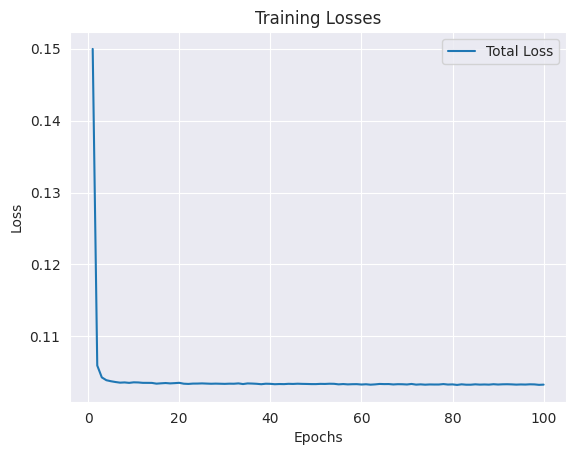

In [16]:
# Plot each line
epochs = range(1, num_epochs+1)
plt.plot(epochs, hist, label='Total Loss')
# plt.plot(epochs, total_mse, label='Total MSE')
# plt.plot(epochs, total_bin, label='Total Bin')

# Add legends, labels, and titles
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')

# Display the plot
plt.show()

In [17]:
test_ticker_string = ['MSFT']
test_data_loader = get_data_loader(TransformerMultiFeaturesDataset, test_ticker_string, look_back=look_back, shuffle=False, train=False)
predicted_ticker = test_ticker_string[0]
print("test data sze (in batches):", len(test_data_loader))
     

test data sze (in batches): 24


In [18]:
# make predictions
y_tests = []
y_tests_bin = []
y_test_preds = []
y_test_preds_bin = []
y_bin = []
y_bin_preds = []

for X_test, y_test in test_data_loader:
    X_test = X_test.to(device)
    y_tests.extend(y_test)
    pred = model(X_test)
    pred = pred.detach().cpu()
    y_test_preds.extend(pred)


# y_tests = test_data_loader.dataset.df['Adj Close'][look_back:].values
y_tests = torch.stack(y_tests).cpu().detach().numpy()
y_test_preds = torch.stack(y_test_preds).cpu().detach().numpy()

# calculate root mean squared error
y_test_preds = np.squeeze(y_test_preds, axis=(2,))
testScore_mse = (mean_squared_error(y_tests, y_test_preds))
print('Test Score: %.5f MSE' % (testScore_mse))

y_tests = test_data_loader.dataset.df['Adj Close']
y_tests = np.array(y_tests)
# N, 1 -> N, 1, D
y_test_preds = np.expand_dims(y_test_preds, axis=2).repeat(input_dim, axis=2)
# N, 1
y_test_preds = test_data_loader.dataset.invert_transform(y_test_preds)
test_price_score = np.sqrt(mean_squared_error(y_tests, y_test_preds))
print('Test Price Score: %.2f RMSE' % (test_price_score))

Test Score: 0.12339 MSE
Test Price Score: 0.78 RMSE


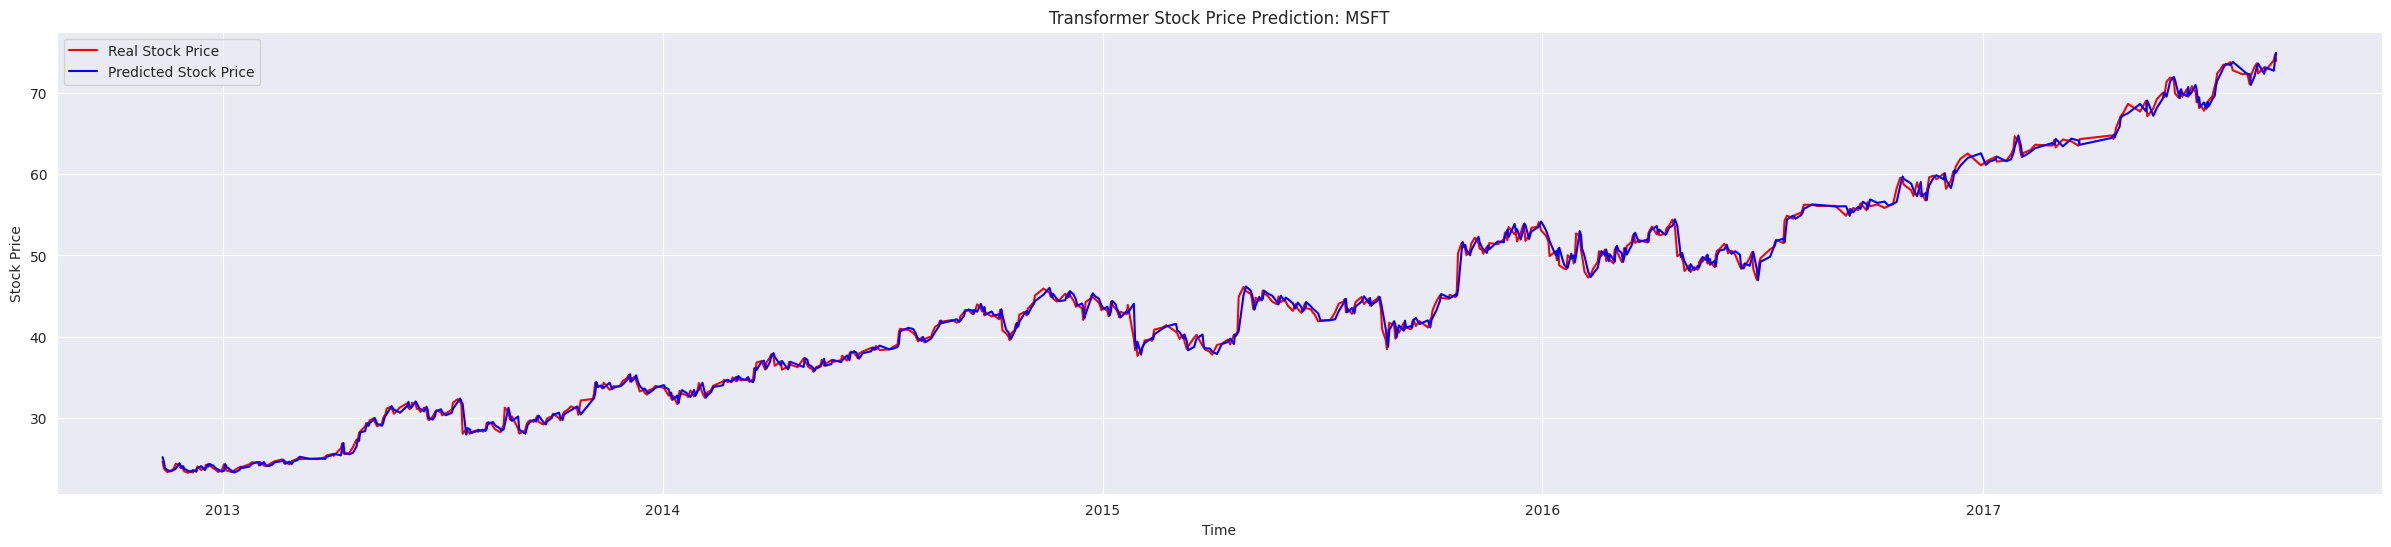

In [19]:
# Visualising the results
figure, axes = plt.subplots(figsize=(30, 6))
axes.xaxis_date()

df = test_data_loader.dataset.df

axes.plot(df.index, y_tests, color = 'red', label = 'Real Stock Price')
axes.plot(df.index, y_test_preds[:,0], color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'Transformer Stock Price Prediction: {predicted_ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
#plt.savefig(f'./plots/transformer_baseline2_pred_{predicted_ticker}.png')
plt.show()

In [20]:
correct_pred = 0
incorrect_pred = 0

count_up = 0
count_down = 0
for i in range(1, len(y_tests)):
    if (y_tests[i] - y_tests[i-1])>0:
      count_up+=1
    else:
      count_down+=1
    if (y_tests[i] - y_tests[i-1]) * (y_test_preds[i] - y_tests[i-1]) > 0:
        correct_pred += 1
    else:
        incorrect_pred += 1

print("Accuracy of predicting rise/drop: ", correct_pred / (correct_pred + incorrect_pred))

Accuracy of predicting rise/drop:  0.5379494007989347
